In [1]:
import cv2
import numpy as np

import pandas as pd
import fitz
import cv2
from io import BytesIO
from PIL import Image
import base64
from openai import OpenAI
from pydantic import BaseModel
import json
import numpy as np
import traceback
from typing import Optional

import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment, Border, Side, Font

from form_class import Form

from ui_functions import get_pic_from_pdf, save_to_excel, get_correct_answers, postprocess_raw_output, check_answers, final_styling, extract_text_from_image, transform_json_to_dataframe
from ui_functions import promt

In [32]:
import cv2
import numpy as np

def find_black_square_in_roi(img, roi_rect, min_area=500, aspect_tol=0.3):
    """
    Ищет "чёрный квадрат" в пределах ROI (x,y,w,h) на картинке img.
    Возвращает (cx, cy) - центр найденного квадрата в ГЛОБАЛЬНЫХ координатах img.
    Если ничего не найдено, вернёт None.
    """
    x, y, w, h = roi_rect
    roi = img[y:y+h, x:x+w]

    # gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = roi
    # Порог подбирайте под конкретное изображение
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best_area = 0
    best_center = None

    # visualize the contours
    for cnt in contours:
        x2, y2, w2, h2 = cv2.boundingRect(cnt)
        cv2.rectangle(roi, (x2, y2), (x2 + w2, y2 + h2), (0, 0, 255), 2)

    plt.imshow(roi)
    plt.show()

    for cnt in contours:
        x2, y2, w2, h2 = cv2.boundingRect(cnt)



        area = w2 * h2
        if area < min_area:
            continue
        aspect = w2 / float(h2)
        if not (1 - aspect_tol <= aspect <= 1 + aspect_tol):
            continue

        if area > best_area:
            best_area = area
            # Центр в локальной (ROI) системе координат
            cx_local = x2 + w2/2
            cy_local = y2 + h2/2
            # Переводим в глобальные координаты изображения
            best_center = (x + cx_local, y + cy_local)

    return best_center


In [91]:
def get_template_corners():
    """
    Возвращает (template_img, [ (x1,y1,w1,h1), (x2,y2,w2,h2), (x3,y3,w3,h3), (x4,y4,w4,h4) ])
    Это заранее известные (или сохранённые) ROI черных квадратов в шаблоне.
    """
    template_img = cv2.imread("template.jpg")
    # Допустим, жёстко зашили или загрузили из JSON.
    # Порядок: [TL, TR, BL, BR]
    scale_x = 170
    scale_y = 170
    scale_w = 0
    scale_h = 0

    corners_rects = [
        (260 - scale_x, 170 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y),
        (3230 - scale_x, 170 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y),  # правый верх
        (260 - scale_x, 4810 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y), # левый низ
        (3230 - scale_x, 4810 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y) # правый низ

    ]

    return template_img, corners_rects


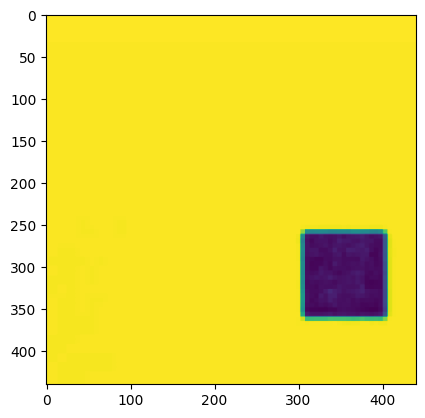

Не смогли найти квадрат в ROI: (90, 0, 440, 440)


In [92]:
def align_page_using_fixed_rois(page_img, output_path):
    # 1. Загружаем шаблон
    template_img, corners_rects = get_template_corners()  # Ваши заранее зашитые ROI
    H, W = template_img.shape[:2]


    # 2. Загружаем заполненный бланк
    h2, w2 = page_img.shape[:2]

    # Приводим страницу к размеру (W, H) (простой ресайз).
    # Можно сделать иначе: подгонять по одной стороне, если вам важно соотношение сторон и т.д.
    page_img_resized = cv2.resize(page_img, (W, H), interpolation=cv2.INTER_AREA)

    # 3. Для каждого из 4 ROI на шаблоне найдём центр квадрата в шаблоне и в page
    template_points = []
    page_points = []

    for (rx, ry, rw, rh) in corners_rects:
        # 3.1. Центр ROI в шаблоне (или можно найти сам "чёрный квадрат" внутри шаблона,
        # но вы говорите, что эти ROI и так точно "угловые квадраты").
        cx_template = rx + rw/2
        cy_template = ry + rh/2
        template_points.append((cx_template, cy_template))

        # 3.2. Ищем этот же квадрат на page (уже ресайзнутом),
        #      но в той же области (rx, ry, rw, rh).
        center_page = find_black_square_in_roi(page_img_resized, (rx, ry, rw, rh))
        if center_page is None:
            # Если не нашли, можно аварийно завершить
            print("Не смогли найти квадрат в ROI:", (rx, ry, rw, rh))
            return

        page_points.append(center_page)

    # Преобразуем в формат для getPerspectiveTransform
    src_pts = np.float32(page_points).reshape(-1,1,2)
    dst_pts = np.float32(template_points).reshape(-1,1,2)

    # 4. Находим перспективное преобразование (page -> template)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # 5. Применяем warpPerspective к (не-ресайзнутой!) оригинальной page или к page_img_resized?
    #    Зависит от того, что вы считаете «истинным» входом.
    #    Чаще разумнее warp'ить исходный page_img, чтобы не терять детализацию.
    #    Но тогда нужно учесть, что точки, которые мы нашли в page_img_resized,
    #    нужно обратно «перевести» в координаты оригинального page_img.
    #
    #    Проще сначала вычислить «масштаб», а потом домножить все page_points, чтобы они
    #    относились к оригиналу. Примерно так:
    scale_x = W / float(w2)
    scale_y = H / float(h2)
    # Если мы делали resize(page, (W,H)), значит масштаб по x = W/w2, y = H/h2.
    # Тогда реальные координаты в original_page = (cx / scale_x, cy / scale_y).

    page_points_orig = []
    for (cx, cy) in page_points:
        real_x = cx / scale_x
        real_y = cy / scale_y
        page_points_orig.append((real_x, real_y))

    src_pts_orig = np.float32(page_points_orig).reshape(-1,1,2)
    dst_pts_orig = np.float32(template_points).reshape(-1,1,2)

    M_orig = cv2.getPerspectiveTransform(src_pts_orig, dst_pts_orig)
    original_aligned = cv2.warpPerspective(page_img, M_orig, (W, H))

    cv2.imwrite(output_path, original_aligned)
    print(f"Сохранено выравненное изображение: {output_path}")

    return original_aligned

pdf_path = "test_pics/valid_format/valid_questions.pdf"
pdf_bytes = open(pdf_path, 'rb').read()
pdf_document = fitz.open(stream=pdf_bytes, filetype="pdf")
num_pages = pdf_document.page_count
cur_pic = get_pic_from_pdf(pdf_bytes, 0, zoom=1.1)

aligned_pic = align_page_using_fixed_rois(cur_pic, "aligned_pic.jpg")


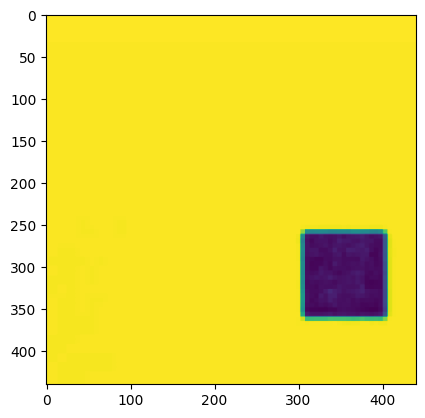

In [93]:
template_img, corners_rects = get_template_corners()  # Ваши заранее зашитые ROI
H, W = template_img.shape[:2]

cur_pic = get_pic_from_pdf(pdf_bytes, 0, zoom=1.1)
cur_pic = cv2.resize(cur_pic, (W, H), interpolation=cv2.INTER_AREA)
scale_x = 170
scale_y = 170
scale_w = 0
scale_h = 0

x, y, w, h = 260 - scale_x, 170 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y

roi = cur_pic[y:y+h, x:x+w].copy()





plt.imshow(roi)
plt.show()




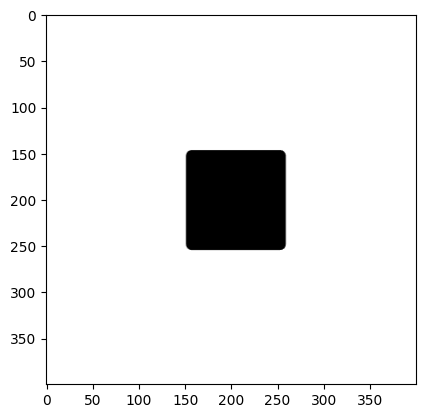

In [85]:
template_img, corners_rects = get_template_corners()  # Ваши заранее зашитые ROI
H, W = template_img.shape[:2]

cur_pic = get_pic_from_pdf(pdf_bytes, 0, zoom=1.1)
cur_pic = cv2.resize(cur_pic, (W, H), interpolation=cv2.INTER_AREA)
scale_x = 150
scale_y = 150
scale_w = 0
scale_h = 0




x, y, w, h = 260 - scale_x, 170 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y
roi = template_img[y:y+h, x:x+w].copy()







plt.imshow(roi)
plt.show()

In [54]:
x

250

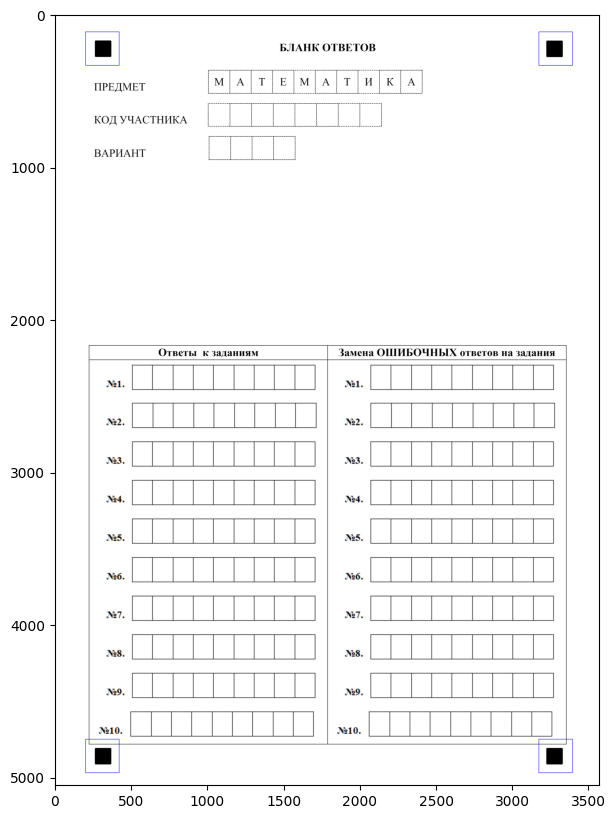

In [23]:
scale = 60
corners_rects = [
    (260 - scale, 170 - scale, 100 + 2*scale, 100 + 2*scale),
    (3230 - scale, 170 - scale, 100 + 2*scale, 100 + 2*scale),  # правый верх
    (260 - scale, 4810 - scale, 100 + 2*scale, 100 + 2*scale), # левый низ
    (3230 - scale, 4810 - scale, 100 + 2*scale, 100 + 2*scale) # правый низ
]




template_img = cv2.imread("template.jpg")

# visualize the corners
for (x, y, w, h) in corners_rects:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 0, 255), 2)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(template_img)
plt.show()



In [ ]:
corners_rects = [
    (260, 170, 100, 100), # верхний левый
    (3230, 170, 100, 100),  # верхний правый
    (260, 4810, 100, 100), # нижний левый
    (3230, 4810, 100, 100) # нижний правый

]

x, y, w, h = 260, 170, 100, 100


In [155]:
for tx, ty in corners_template:
    print(tx, ty)


260.0 170.0
3230.0 170.0
260.0 4810.0
3230.0 4810.0


In [161]:
num_pages


13

In [ ]:
import cv2
import numpy as np

# Загружаем изображения (предположим, что они уже загружены)
for i in range(num_pages):
    print(i)
    cur_pic = get_pic_from_pdf(pdf_bytes, i, zoom=2.0)
    # cur_pic = cv2.imread("template.jpg")
    template_img = cv2.imread("template.jpg")

    corners_template = np.float32([
        (260 , 170),  # Верхний левый
        (3230 , 170),  # Верхний правый
        (260 , 4810),  # Нижний левый

        (3230, 4810)  # Нижний правый
    ])
    H, W = template_img.shape[:2]
    cut_pic = cv2.resize(cur_pic, (W, H), interpolation=cv2.INTER_AREA)

    def get_contours(image):
        # Загрузка изображения

        # Инвертируем изображение (пунктирные линии должны быть белыми)
        _, binary = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY_INV)
        # print(binary.shape)

        # Применяем размытие, чтобы убрать шум
        blurred = cv2.GaussianBlur(binary, (5, 5), 0)
        # print(blurred.shape)

        # Используем морфологию для выделения прямоугольных структур
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        processed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel, iterations=1)
        # print(processed.shape)


        # Поиск контуров
        contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=lambda x: x[0][0][1])
        contours = sorted(contours, key=lambda x: x[0][0][0])
        contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

        # Копия изображения для отображения результатов
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        # print(output.shape)

        # Фильтруем и выделяем только прямоугольные блоки
        contours_valid = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Условие для фильтрации блоков по размеру
            if 100 < w < 150 and 100 < h < 200:  # Подстраивайте размеры под бланк
                contours_valid.append(contour)
                cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        return contours_valid, output

    # Функция для нахождения квадратов в cut_pic
    def find_squares(image, template_corners):
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = image

        contours, output = get_contours(gray)
        # print(len(contours))
        # plt.figure(figsize=(10, 10))
        # plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.show()

        gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        # visualize the contours
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)


        # plt.figure(figsize=(10, 10))
        # plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.show()

        global test_gray
        test_gray = gray

        global test_output
        test_output = output
        found_corners = []
        for cnt in contours:


            x, y, w, h = cv2.boundingRect(cnt)
            center = (x + w // 2, y + h // 2)

            # Фильтруем по размеру и положению
            for tx, ty in template_corners:
                # print(tx, ty, center[0], center[1])
                if abs(tx - center[0]) < 250 and abs(ty - center[1]) < 200:
                    # print(tx, ty, center[0], center[1])
                    # print("found", tx, ty, center[0], center[1])
                    found_corners.append(center)
                    break






        # sort the found_corners by x and y
        found_corners = sorted(found_corners, key=lambda x: x[0])
        found_corners = sorted(found_corners, key=lambda x: x[1])
        print('len', len(found_corners))
        return np.float32(found_corners) if len(found_corners) == 4 else None




    # Находим квадраты в cut_pic
    corners_cut = find_squares(cut_pic, corners_template)

    if corners_cut is not None:
        # Вычисляем матрицу преобразования
        matrix = cv2.getPerspectiveTransform(corners_cut, corners_template)
        
        # Применяем преобразование
        aligned_cut_pic = cv2.warpPerspective(cut_pic, matrix, (template_img.shape[1], template_img.shape[0]))

        # Сохраняем или показываем результат
        cv2.imwrite("aligned_cut_pic.jpg", aligned_cut_pic)

    else:
        print("Не удалось найти все 4 квадрата в cut_pic")




0
len 4
1
len 4
2
len 4
3
len 4
4
len 4
5
len 4
6
len 4
7
len 4
8
len 4
9
len 4
10
len 4
11
len 4
12
len 4


In [ ]:
260.0 170.0
3230.0 170.0
260.0 4810.0
3230.0 4810.0

In [136]:
cur_pic.shape

(5051, 3571, 3)

In [138]:
template_img.shape

(5051, 3571, 3)

In [ ]:
    global test_gray
    test_gray = gray

    global test_output
    test_output = output

In [133]:
test_gray.shape


(5051, 3571)

In [134]:
test_output.shape


(5051, 3571, 3)

In [ ]:
cur_pic = get_pic_from_pdf(pdf_bytes, i, zoom=2.0)
# cur_pic = cv2.imread("template.jpg")
template_img = cv2.imread("template.jpg")

def get_alligned_pic(cur_pic, template_img):
    corners_template = np.float32([
        (260 , 170),  # Верхний левый
        (3230 , 170),  # Верхний правый
        (260 , 4810),  # Нижний левый

        (3230, 4810)  # Нижний правый
    ])
    H, W = template_img.shape[:2]
    cut_pic = cv2.resize(cur_pic, (W, H), interpolation=cv2.INTER_AREA)

    def get_contours(image):
        # Загрузка изображения

        # Инвертируем изображение (пунктирные линии должны быть белыми)
        _, binary = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY_INV)
        # print(binary.shape)

        # Применяем размытие, чтобы убрать шум
        blurred = cv2.GaussianBlur(binary, (5, 5), 0)
        # print(blurred.shape)

        # Используем морфологию для выделения прямоугольных структур
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        processed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel, iterations=1)
        # print(processed.shape)


        # Поиск контуров
        contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=lambda x: x[0][0][1])
        contours = sorted(contours, key=lambda x: x[0][0][0])
        contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

        # Копия изображения для отображения результатов
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        # print(output.shape)

        # Фильтруем и выделяем только прямоугольные блоки
        contours_valid = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Условие для фильтрации блоков по размеру
            if 100 < w < 150 and 100 < h < 200:  # Подстраивайте размеры под бланк
                contours_valid.append(contour)
                cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        return contours_valid, output

    # Функция для нахождения квадратов в cut_pic
    def find_squares(image, template_corners):
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = image

        contours, output = get_contours(gray)
        # print(len(contours))
        # plt.figure(figsize=(10, 10))
        # plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.show()

        gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        # visualize the contours
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)


        # plt.figure(figsize=(10, 10))
        # plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.show()

        global test_gray
        test_gray = gray

        global test_output
        test_output = output
        found_corners = []
        for cnt in contours:


            x, y, w, h = cv2.boundingRect(cnt)
            center = (x + w // 2, y + h // 2)

            # Фильтруем по размеру и положению
            for tx, ty in template_corners:
                # print(tx, ty, center[0], center[1])
                if abs(tx - center[0]) < 250 and abs(ty - center[1]) < 200:
                    # print(tx, ty, center[0], center[1])
                    # print("found", tx, ty, center[0], center[1])
                    found_corners.append(center)
                    break






        # sort the found_corners by x and y
        found_corners = sorted(found_corners, key=lambda x: x[0])
        found_corners = sorted(found_corners, key=lambda x: x[1])
        print('len', len(found_corners))
        return np.float32(found_corners) if len(found_corners) == 4 else None




    # Находим квадраты в cut_pic
    corners_cut = find_squares(cut_pic, corners_template)

    if corners_cut is not None:
        # Вычисляем матрицу преобразования
        matrix = cv2.getPerspectiveTransform(corners_cut, corners_template)
        
        # Применяем преобразование
        aligned_cut_pic = cv2.warpPerspective(cut_pic, matrix, (template_img.shape[1], template_img.shape[0]))

        # Сохраняем или показываем результат
        cv2.imwrite("aligned_cut_pic.jpg", aligned_cut_pic)

    else:
        print("Не удалось найти все 4 квадрата в cut_pic")

    return aligned_cut_pic
